In [75]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from scipy.stats import shapiro, f_oneway, ttest_ind, ttest_rel
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import random

import matplotlib.pyplot as plt

%matplotlib inline

In [121]:
!git clone https://github.com/arthuralvim/valorian-selecao-ia.git valorian

Cloning into 'valorian'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 22 (delta 5), reused 15 (delta 2), pack-reused 0
Unpacking objects: 100% (22/22), 22.33 MiB | 10.91 MiB/s, done.


## Parâmetros Utilizados

In [6]:
random.seed(333)

RND_STATE = 333
ITERATIONS = 30
RND_SEEDS = random.sample(population=range(100), k=ITERATIONS)
ALPHA = 0.05

## Conjunto de Dados

Aqui faço o carregamento do conjunto de dados.

In [7]:
pickle_path = '/content/valorian/coleta-processed.pkl'
dataset = pd.read_pickle(pickle_path)

In [8]:
dataset.head()

,timestamp_min,timestamp_max,acelerometer_x,acelerometer_y,acelerometer_z,target
0,1970-01-01 00:16:54.750,1970-01-01 00:16:57.000,6.783143,6.670286,-0.631143,Downstairs
1,1970-01-01 00:16:57.000,1970-01-01 00:16:59.250,2.620444,9.254889,-3.152222,Downstairs
2,1970-01-01 00:16:59.250,1970-01-01 00:17:01.500,1.591591,8.997045,-2.703182,Downstairs
3,1970-01-01 00:17:01.500,1970-01-01 00:17:03.750,1.025870,9.708696,-2.767174,Downstairs
4,1970-01-01 00:17:03.750,1970-01-01 00:17:06.000,2.612444,9.157778,-3.711333,Downstairs


In [9]:
X = dataset[["acelerometer_x", "acelerometer_y", "acelerometer_z"]]

In [10]:
X.shape

(19721, 3)

In [11]:
LE = LabelEncoder()
y = LE.fit_transform(dataset['target'])

In [12]:
pd.DataFrame(y).value_counts(normalize=True)

5    0.333350
1    0.313473
4    0.128847
0    0.107297
2    0.063891
3    0.053141
dtype: float64

Como observado no caderno anterior temos um conjunto de dados desbalanceado. Para efeitos de estudo vamos considerar situações de super e sub amostragem para comparação.

In [13]:
rus = RandomUnderSampler(random_state=RND_STATE)
X_undersampled, y_undersampled = rus.fit_resample(X, y)
X_undersampled.shape
print(sorted(Counter(y_undersampled).items()))

[(0, 1048), (1, 1048), (2, 1048), (3, 1048), (4, 1048), (5, 1048)]


In [14]:
ros = RandomOverSampler(random_state=RND_STATE)
X_oversampled, y_oversampled = ros.fit_resample(X, y)
X_oversampled.shape
print(sorted(Counter(y_oversampled).items()))

[(0, 6574), (1, 6574), (2, 6574), (3, 6574), (4, 6574), (5, 6574)]


## Modelos

Nessa seção instanciamos os modelos básicos de cada técnica, realizamos o treinamento e validação para cada uma das bases geradas.

In [17]:
from collections import namedtuple
from time import perf_counter

Result = namedtuple("Result", "model acc rmse")


class ElapsedTime:
    def __enter__(self):
        self.time = perf_counter()
        return self

    def __exit__(self, type, value, traceback):
        self.time = perf_counter() - self.time
        self.readout = f'Time: {self.time:.3f} seconds'
        print(self.readout)

def execute(features, targets, number_iterations=ITERATIONS, suffix="all"):
  xgboost_results = []
  rnd_forest_results = []

  for n in range(0, number_iterations):

    print(f"Execution #{n}")
    
    with ElapsedTime() as t:

        x_train, x_test, y_train, y_test = train_test_split(features, targets, 
                                                            test_size=0.30, 
                                                            stratify=targets,
                                                            random_state=RND_SEEDS[n])


        xgboost_model = xgb.XGBClassifier(n_estimators=1000)
        xgboost_model.fit(x_train, y_train)
        y_pred = xgboost_model.predict(x_test)
        result_xgboost = Result(model=xgboost_model, 
                acc=accuracy_score(y_test, y_pred),
                rmse=mean_squared_error(y_test, y_pred, squared=False))

        xgboost_results.append(result_xgboost)

        rnd_forest_model = RandomForestClassifier(n_estimators=1000)
        rnd_forest_model.fit(x_train, y_train)
        y_pred = rnd_forest_model.predict(x_test)
        result_rnd_forest = Result(model=rnd_forest_model, 
                acc=accuracy_score(y_test, y_pred),
                rmse=mean_squared_error(y_test, y_pred, squared=False))

        rnd_forest_results.append(result_rnd_forest)

  for result in xgboost_results:
    insert_result('xgboost', result.acc, result.rmse, suffix)
  
  for result in rnd_forest_results:
    insert_result('rnd_forest', result.acc, result.rmse, suffix)

  return xgboost_results, rnd_forest_results

def insert_result(model_name, accuracy, rmse, suffix="all"):
  results['rmse_' + suffix][model_name].append(rmse)
  results['accuracy_' + suffix][model_name].append(accuracy)

In [18]:
results = {
  'rmse_all': {
      'xgboost': [],
      'rnd_forest': [],
  },
  'accuracy_all': {
      'xgboost': [],
      'rnd_forest': [],
  },
  'rmse_under': {
      'xgboost': [],
      'rnd_forest': [],
  },
  'accuracy_under': {
      'xgboost': [],
      'rnd_forest': [],
  },
  'rmse_over': {
      'xgboost': [],
      'rnd_forest': [],
  },
  'accuracy_over': {
      'xgboost': [],
      'rnd_forest': [],
  },
}

## Execução

In [19]:
%%time
xgboost_results_all, rnd_forest_results_all = execute(features=X, targets=y, suffix="all")
print(results)

Execution #0 :
Time: 42.199 seconds
Execution #1 :
Time: 38.734 seconds
Execution #2 :
Time: 39.618 seconds
Execution #3 :
Time: 42.300 seconds
Execution #4 :
Time: 43.739 seconds
Execution #5 :
Time: 44.902 seconds
Execution #6 :
Time: 45.946 seconds
Execution #7 :
Time: 46.634 seconds
Execution #8 :
Time: 47.754 seconds
Execution #9 :
Time: 48.739 seconds
Execution #10 :
Time: 50.404 seconds
Execution #11 :
Time: 51.483 seconds
Execution #12 :
Time: 52.319 seconds
Execution #13 :
Time: 53.450 seconds
Execution #14 :
Time: 54.329 seconds
Execution #15 :
Time: 55.164 seconds
Execution #16 :
Time: 55.192 seconds
Execution #17 :
Time: 54.833 seconds
Execution #18 :
Time: 55.454 seconds
Execution #19 :
Time: 56.092 seconds
Execution #20 :
Time: 55.626 seconds
Execution #21 :
Time: 55.346 seconds
Execution #22 :
Time: 55.761 seconds
Execution #23 :
Time: 55.902 seconds
Execution #24 :
Time: 55.776 seconds
Execution #25 :
Time: 56.629 seconds
Execution #26 :
Time: 55.842 seconds
Execution #

In [20]:
 %%time
xgboost_results_under, rnd_forest_results_under = execute(features=X_undersampled, targets=y_undersampled, suffix="under")
print(results)

Execution #0 :
Time: 11.951 seconds
Execution #1 :
Time: 13.083 seconds
Execution #2 :
Time: 16.999 seconds
Execution #3 :
Time: 19.188 seconds
Execution #4 :
Time: 21.085 seconds
Execution #5 :
Time: 19.471 seconds
Execution #6 :
Time: 19.506 seconds
Execution #7 :
Time: 18.477 seconds
Execution #8 :
Time: 18.316 seconds
Execution #9 :
Time: 18.255 seconds
Execution #10 :
Time: 18.985 seconds
Execution #11 :
Time: 19.136 seconds
Execution #12 :
Time: 18.584 seconds
Execution #13 :
Time: 22.110 seconds
Execution #14 :
Time: 21.548 seconds
Execution #15 :
Time: 20.670 seconds
Execution #16 :
Time: 20.780 seconds
Execution #17 :
Time: 19.805 seconds
Execution #18 :
Time: 19.589 seconds
Execution #19 :
Time: 19.489 seconds
Execution #20 :
Time: 20.010 seconds
Execution #21 :
Time: 19.659 seconds
Execution #22 :
Time: 20.452 seconds
Execution #23 :
Time: 20.441 seconds
Execution #24 :
Time: 20.196 seconds
Execution #25 :
Time: 21.695 seconds
Execution #26 :
Time: 20.753 seconds
Execution #

In [21]:
%%time
xgboost_results_over, rnd_forest_results_over = execute(features=X_oversampled, targets=y_oversampled, suffix="over")
print(results)

Execution #0 :
Time: 98.991 seconds
Execution #1 :
Time: 100.432 seconds
Execution #2 :
Time: 100.335 seconds
Execution #3 :
Time: 103.026 seconds
Execution #4 :
Time: 135.779 seconds
Execution #5 :
Time: 110.503 seconds
Execution #6 :
Time: 103.741 seconds
Execution #7 :
Time: 97.320 seconds
Execution #8 :
Time: 111.312 seconds
Execution #9 :
Time: 102.757 seconds
Execution #10 :
Time: 102.076 seconds
Execution #11 :
Time: 101.202 seconds
Execution #12 :
Time: 98.079 seconds
Execution #13 :
Time: 99.154 seconds
Execution #14 :
Time: 101.531 seconds
Execution #15 :
Time: 112.618 seconds
Execution #16 :
Time: 108.500 seconds
Execution #17 :
Time: 104.360 seconds
Execution #18 :
Time: 108.720 seconds
Execution #19 :
Time: 107.268 seconds
Execution #20 :
Time: 104.297 seconds
Execution #21 :
Time: 118.204 seconds
Execution #22 :
Time: 112.655 seconds
Execution #23 :
Time: 106.859 seconds
Execution #24 :
Time: 114.372 seconds
Execution #25 :
Time: 96.401 seconds
Execution #26 :
Time: 93.43

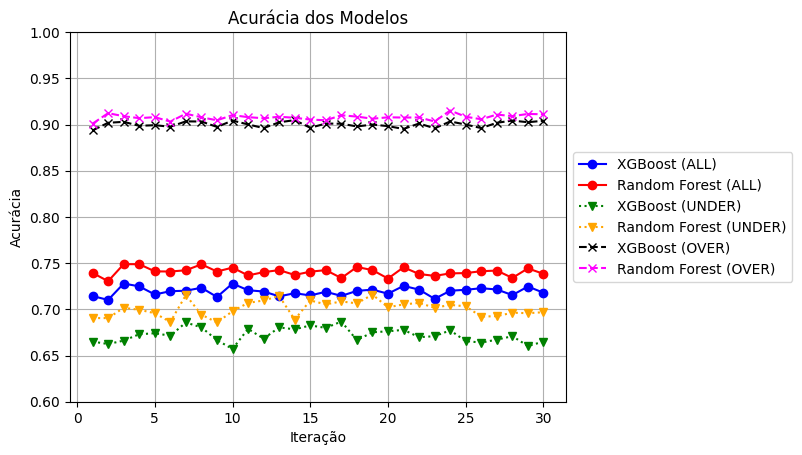

In [53]:
iterations = range(1, ITERATIONS + 1)
plt.plot(iterations, results['accuracy_all']['xgboost'], label="XGBoost (ALL)", color='blue', marker='o', linestyle='solid')
plt.plot(iterations, results['accuracy_all']['rnd_forest'], label="Random Forest (ALL)", color='red', marker='o', linestyle='solid')

plt.plot(iterations, results['accuracy_under']['xgboost'], label="XGBoost (UNDER)", color='green', marker='v', linestyle='dotted') 
plt.plot(iterations, results['accuracy_under']['rnd_forest'], label="Random Forest (UNDER)", color='orange', marker='v', linestyle='dotted') 

plt.plot(iterations, results['accuracy_over']['xgboost'], label="XGBoost (OVER)", color='black', marker='x', linestyle='dashed') 
plt.plot(iterations, results['accuracy_over']['rnd_forest'], label="Random Forest (OVER)", color='magenta', marker='x', linestyle='dashed') 

plt.title("Acurácia dos Modelos")
plt.xlabel("Iteração")
plt.ylabel("Acurácia")
plt.ylim([0.6, 1])
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

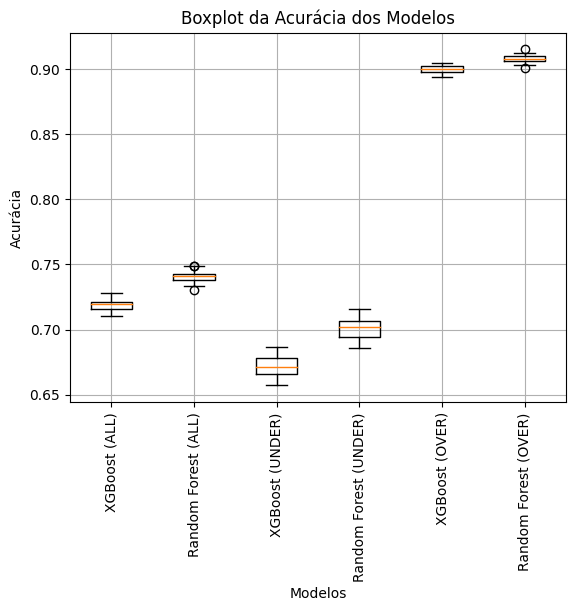

In [85]:
plt.boxplot(x=[
             results['accuracy_all']['xgboost'], 
             results['accuracy_all']['rnd_forest'],
             results['accuracy_under']['xgboost'],
             results['accuracy_under']['rnd_forest'],
             results['accuracy_over']['xgboost'],
             results['accuracy_over']['rnd_forest']
            ],
            labels=[
             'XGBoost (ALL)',
             'Random Forest (ALL)',
             'XGBoost (UNDER)',
             'Random Forest (UNDER)',
             'XGBoost (OVER)',
             'Random Forest (OVER)',
            ])

plt.title("Boxplot da Acurácia dos Modelos")
plt.xlabel("Modelos")
plt.ylabel("Acurácia")
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

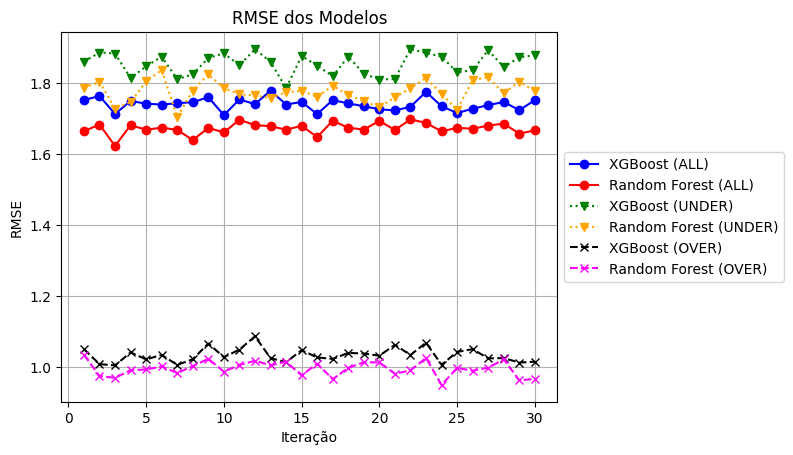

In [54]:
iterations = range(1, ITERATIONS + 1)
plt.plot(iterations, results['rmse_all']['xgboost'], label="XGBoost (ALL)", color='blue', marker='o', linestyle='solid')
plt.plot(iterations, results['rmse_all']['rnd_forest'], label="Random Forest (ALL)", color='red', marker='o', linestyle='solid')

plt.plot(iterations, results['rmse_under']['xgboost'], label="XGBoost (UNDER)", color='green', marker='v', linestyle='dotted') 
plt.plot(iterations, results['rmse_under']['rnd_forest'], label="Random Forest (UNDER)", color='orange', marker='v', linestyle='dotted') 

plt.plot(iterations, results['rmse_over']['xgboost'], label="XGBoost (OVER)", color='black', marker='x', linestyle='dashed') 
plt.plot(iterations, results['rmse_over']['rnd_forest'], label="Random Forest (OVER)", color='magenta', marker='x', linestyle='dashed') 

plt.title("RMSE dos Modelos")
plt.xlabel("Iteração")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Teste Estatísticos e Conclusões finais

In [45]:
print("%f pvalor accuracy_all - xgboost " % shapiro(results['accuracy_all']['xgboost'])[1])
print("%f pvalor accuracy_under - xgboost " % shapiro(results['accuracy_under']['xgboost'])[1])
print("%f pvalor accuracy_over - xgboost " % shapiro(results['accuracy_over']['xgboost'])[1])
print("%f pvalor accuracy_all - rnd_forest " % shapiro(results['accuracy_all']['rnd_forest'])[1])
print("%f pvalor accuracy_under - rnd_forest " % shapiro(results['accuracy_under']['rnd_forest'])[1])
print("%f pvalor accuracy_over - rnd_forest " % shapiro(results['accuracy_over']['rnd_forest'])[1])

0.872652 pvalor accuracy_all - xgboost 
0.730926 pvalor accuracy_under - xgboost 
0.200530 pvalor accuracy_over - xgboost 
0.700524 pvalor accuracy_all - rnd_forest 
0.580512 pvalor accuracy_under - rnd_forest 
0.970265 pvalor accuracy_over - rnd_forest 


H0: As acurácias seguem uma distribuição normal.

H1: As acurácias não seguem uma distribuição normal.

Todos os pvalores são maiores que o nível de significância estabelecido (5%). Logo não rejeitamos a hipótese de que os dados seguem uma distribuição normal.

In [44]:
print("%f pvalor para o teste ANOVA - acurácia" % f_oneway(
    results['accuracy_all']['xgboost'],
    results['accuracy_under']['xgboost'],
    results['accuracy_over']['xgboost'],
    results['accuracy_all']['rnd_forest'],
    results['accuracy_under']['rnd_forest'],
    results['accuracy_over']['rnd_forest'],
)[1])

0.000000 pvalue para o teste ANOVA - acurácia


Verificamos aqui, através do pvalor do teste ANOVA, que existe uma diferença estatística entre a média da acurácia dos classificadores.

Após considerar normalidade para as distribuições dos valores de acurária dos algoritmos temos 3 cenários onde serão avaliados o desempenho do *XGBoost* frente ao *RandomForest*: *ALL* (conjunto de dados desbalanceado), *UNDER* (conjunto de dados com subamostragem) e *OVER* (conjunto de dados com superamostragem).

In [49]:
print("%f pvalor xgboost (ALL) x rnd_forest (ALL)" % ttest_ind(results['accuracy_all']['xgboost'], results['accuracy_all']['rnd_forest'], alternative="two-sided").pvalue)
print("%f pvalor xgboost (UNDER) x rnd_forest (UNDER)" % ttest_ind(results['accuracy_under']['xgboost'], results['accuracy_under']['rnd_forest'], alternative="two-sided").pvalue)
print("%f pvalor xgboost (OVER) x rnd_forest (OVER)" % ttest_ind(results['accuracy_over']['xgboost'], results['accuracy_over']['rnd_forest'], alternative="two-sided").pvalue)

0.000000 pvalor xgboost (ALL) x rnd_forest (ALL)
0.000000 pvalor xgboost (UNDER) x rnd_forest (UNDER)
0.000000 pvalor xgboost (OVER) x rnd_forest (OVER)


H0: u(a) == u(b)

H1: u(a) != u(b)

Como todos os pvalores foram muito baixos (< 0,001), ao nível de significância de 5%, rejeita-se a hipótese nula. Logo existe diferença significativa entre as médias da população de acurária dos classificadores (teste T - *two-sided*).

In [96]:
print("%f pvalor xgboost (ALL) x rnd_forest (ALL)" % ttest_rel(b=results['accuracy_all']['xgboost'], a=results['accuracy_all']['rnd_forest'], alternative='greater').pvalue)
print("%f pvalor xgboost (UNDER) x rnd_forest (UNDER)" % ttest_rel(b=results['accuracy_under']['xgboost'], a=results['accuracy_under']['rnd_forest'], alternative="greater").pvalue)
print("%f pvalor xgboost (OVER) x rnd_forest (OVER)" % ttest_rel(b=results['accuracy_over']['xgboost'], a=results['accuracy_over']['rnd_forest'], alternative="greater").pvalue)

0.000000 pvalor xgboost (ALL) x rnd_forest (ALL)
0.000000 pvalor xgboost (UNDER) x rnd_forest (UNDER)
0.000000 pvalor xgboost (OVER) x rnd_forest (OVER)


H0: u(a) == u(b)

H1: u(a) > u(b)

Como todos os pvalores foram menores que o nível de significância (5%), rejeitamos a hipótese (teste T - *greater*). Logo a média da distribuição de acurácia do RandomForest é maior que a do XGBoost.

Para futuro:
* Validar se é possível utilizar outras técnicas de amostragem.
* Investigar/Buscar/Otimizar parâmetros de cada algoritmo usando possivelmente o GridSearchCV.
* Testar uma mistura de classificadores com as duas técnicas.